In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
from sklearn.decomposition import PCA

Зчитуємо дані

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/OHrydko/Machine-Learning-Labs/master/lab1/MP-07-Hrydko.csv', 
                 header= None, names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'y'], sep=';',engine='python')

df[df.columns[:-1]] = df[df.columns[:-1]]/df[df.columns[:-1]].max()

df.head()

,x0,x1,x2,x3,x4,x5,y
0,0.725212,0.415858,0.634122,0.357160,0.530405,0.554634,9.726
1,0.245487,0.177885,0.237784,0.245964,0.091216,0.856229,17.395
2,0.135193,0.142456,0.155589,0.138395,0.074324,0.920853,2.375
3,0.254499,0.175166,0.227307,0.227887,0.084459,0.822141,12.987
4,0.135586,0.169278,0.154254,0.192055,0.057432,0.855559,5.562


Виділяємо дві головні компоненти

Вектор середніх:  [1.         0.35940775 0.33663931 0.36420301 0.2700529  0.24577027
 0.73666244]
Вибіркова дисперсія:  [0.13125005 0.01776678]
Частина загальної дисперсії:  [0.8201869  0.11102535]


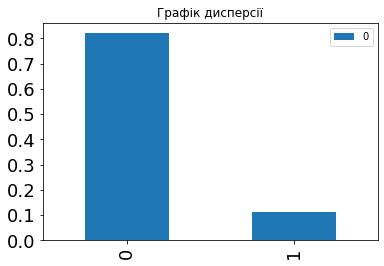

In [9]:
x_train = df[df.columns[:-1]].values
pca = PCA(n_components=2)
x = pca.fit_transform(x_train)
print('Вектор середніх: ', pca.mean_)
print('Вибіркова дисперсія: ', pca.explained_variance_)
print('Частина загальної дисперсії: ', pca.explained_variance_ratio_)
variance_ratio = pca.explained_variance_ratio_
variance_ratio = pd.DataFrame(variance_ratio)
variance_ratio.plot.bar(title = 'Графік дисперсії', fontsize = 18)

визначаємо скільки параметрів треба взяти, щоб їх сумарний внесок в дисперсію був 60%, 80%, 98% та мінамальна кількість параметрів для 90%

Потрібно взяти 1 параметр при дисперсії = 0.6
Потрібно взяти 1 параметр при дисперсії = 0.8
Потрібно взяти 2 параметр при дисперсії = 0.9
Потрібно взяти 4 параметр при дисперсії = 0.98


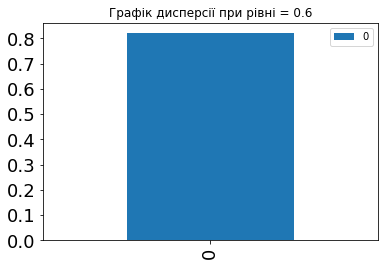

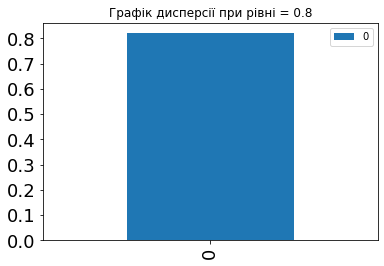

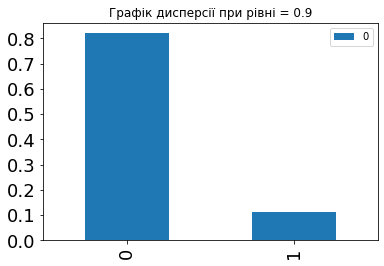

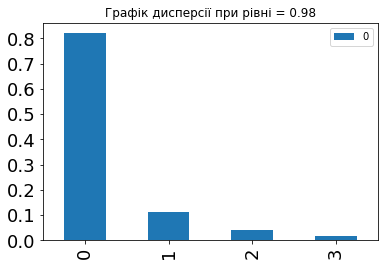

In [11]:
variance = [0.6, 0.8, 0.9, 0.98]
# при svd_solver = 'full' в n_components можна передати дисперсію відповідного рівня
for i in variance:
    pca = PCA(n_components=i, svd_solver = 'full')
    x_res = pca.fit_transform(x_train)
    print('Потрібно взяти {} параметр при дисперсії = {}'.format(pca.n_components_, i))
    variance_ratio = pca.explained_variance_ratio_
    variance_ratio = pd.DataFrame(variance_ratio)
    variance_ratio.plot.bar(title = 'Графік дисперсії при рівні = {}'.format(i), fontsize = 18)

Модель множинної регресії з 1 лабораторної, сумарний внесок в дисперсію = 98%

In [12]:
pca = PCA(n_components=0.98, svd_solver = 'full')
x_res = pca.fit_transform(x_train)

y = df['y'].values
y_train = y[:200]
test_y = y[200:]

test_x = np.ones(50).reshape(50, 1)
test_x = np.append(test_x, x_res[200:], axis=1)

matrix_x = np.ones(200).reshape(200, 1)
matrix_x = np.append(matrix_x, x_res[:200], axis=1)
# визначення параметрів
system_len = pca.n_components_ + 1
alpha = 0.9
# знаходження коефіцієнтів

solve = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_x), matrix_x)), np.transpose(matrix_x)), y_train)
# Оцінка статистичної значимості коефіцієнтів
# Відхилення
q_e = (y_train - (np.dot(matrix_x, solve)))
# Оцінка дисперсії
s_2 = (q_e**2).sum()/(len(y_train) - system_len)
# Коефіцієнти зв'язку
K_coef = np.sqrt(np.diag(s_2 * np.linalg.inv(np.dot(np.transpose(matrix_x), matrix_x))))

t_student = round(sts.t.ppf((1 + alpha)/2, len(y_train) - system_len), 2)
t_calculated = (np.absolute(solve)/K_coef).round(2)
weight_coef = t_calculated > t_student

# Розрахунок коефіцієнта множинної детермінації
R = round(np.sqrt((np.dot(np.dot(np.transpose(solve), np.transpose(matrix_x)), y_train) -
             len(y_train) * y_train.mean())/\
    (np.dot(np.transpose(y_train), y_train) - len(y_train) * y_train.mean())), 2)
print('Значення розподілу t = {} при параметрах alpha = {} & p = {} при'.format(t_student, alpha, len(y_train) - system_len))
for i in range(len(solve)):
    print('b{} = {} значущий {} значення t роподілу = {} '
          .format(i, round(solve[i], 2), weight_coef[i], t_calculated[i]))
print('Коефіцієнт детермінації R = {}, R^2 = {},оцінка дисперції s^2 = {}'.format(R, round(R**2, 2), round(s_2, 2)))

Значення розподілу t = 1.65 при параметрах alpha = 0.9 & p = 195 при
b0 = 7.48 значущий True значення t роподілу = 20.19 
b1 = -0.64 значущий False значення t роподілу = 0.61 
b2 = 7.56 значущий True значення t роподілу = 2.71 
b3 = 38.56 значущий True значення t роподілу = 8.31 
b4 = -3.25 значущий False значення t роподілу = 0.45 
Коефіцієнт детермінації R = 0.83, R^2 = 0.69,оцінка дисперції s^2 = 27.38


In [13]:
pca_error = ((test_y - (np.dot(test_x,solve)))**2).mean()
print(pca_error)

28.61999648982713


Модель множиної регресії без алгоритму PCA

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/OHrydko/Machine-Learning-Labs/master/lab1/MP-07-Hrydko.csv', 
                 header= None, names=['x1', 'x2', 'x3', 'x4', 'x5','x6', 'y'], sep=';',engine='python')

df[df.columns[:-1]] = df[df.columns[:-1]]/df[df.columns[:-1]].max()
df = df.reset_index()
df = df.rename(columns={'index': 'x0'})
df['x0'] = 1
train = df.iloc[:200]
test = df.iloc[200:]
# визначення параметрів
system_len = len(train.columns)
alpha = 0.9
# знаходження коефіцієнтів
matrix_x = train[train.columns[:-1]].values
solve = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_x), matrix_x)), np.transpose(matrix_x)), train['y'].values)

# Оцінка статистичної значимості коефіцієнтів
# Відхилення
q_e = (train['y'] - (np.dot(train[train.columns[:-1]],solve)))
# Оцінка дисперсії
s_2 = (q_e**2).sum()/(len(train) - system_len)
# Коефіцієнти зв'язку
K_coef = np.sqrt(np.diag(s_2 * np.linalg.inv(np.dot(np.transpose(matrix_x), matrix_x))))

t_student = round(sts.t.ppf((1 + alpha)/2, len(train) - system_len), 2)
t_calculated = (np.absolute(solve)/K_coef).round(2)
weight_coef = t_calculated > t_student

# Розрахунок коефіцієнта множинної детермінації
R = round(np.sqrt((np.dot(np.dot(np.transpose(solve), np.transpose(matrix_x)), train['y'].values) -
             len(train) * train['y'].mean())/\
    (np.dot(np.transpose(train['y'].values), train['y'].values) - len(train) * train['y'].mean())), 2)
print('Значення розподілу t = {} при параметрах alpha = {} & p = {} при'.format(t_student, alpha, len(train) - system_len))
for i in range(len(solve)):
    print('b{} = {} значущий {} значення t роподілу = {} '
          .format(i, round(solve[i], 2), weight_coef[i], t_calculated[i]))
print('Коефіцієнт детермінації R = {}, R^2 = {},оцінка дисперції s^2 = {}'.format(R, round(R**2, 2), round(s_2, 2)))

Значення розподілу t = 1.65 при параметрах alpha = 0.9 & p = 192 при
b0 = 14.25 значущий True значення t роподілу = 1.89 
b1 = 20.35 значущий True значення t роподілу = 3.11 
b2 = -42.25 значущий True значення t роподілу = 5.73 
b3 = 16.49 значущий False значення t роподілу = 1.44 
b4 = -17.19 значущий True значення t роподілу = 2.27 
b5 = 9.48 значущий True значення t роподілу = 3.76 
b6 = -4.78 значущий False значення t роподілу = 0.64 
Коефіцієнт детермінації R = 0.84, R^2 = 0.71,оцінка дисперції s^2 = 26.23


In [15]:
error_mnk = ((test['y'] - (np.dot(test[test.columns[:-1]],solve)))**2).mean()
print(error_mnk)

28.355489620345523
